# Determine clonality of CLL cells, draw some more visualizations and train a decision tree

In [1]:
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, ListedColormap
from itertools import combinations
from scipy.stats import mannwhitneyu
from sklearn import tree
from sklearn.metrics import roc_curve, auc

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_use_gpu' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
os.chdir('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure5/'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)
sc.settings.n_jobs = 40

In [3]:
# read md
data_dir = '../data/raw/Flow cytometry/CLL/full_cohort/'
md = pd.read_csv(f'{data_dir}CytoVI_CLL_md_combined_updated.csv', dtype={'donor': str})
adata = ad.read('../data/raw/Flow cytometry/CLL/full_cohort/processed/2025-01-13_CLL_full_cohort_latent_annot_labels_transfered.h5ad')

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
# compute kappa lambda ratio
adata_cll = adata[(adata.obs['cell_type']=='CLL cells') & (adata.obs['group']== 'cases') & (adata.obs['model_type']=='query')].copy()
k_l_ratio = np.array((adata_cll[:,'Kappa'].layers['scaled'].flatten())/ (adata_cll[:,'Lambda'].layers['scaled'].flatten()))
adata_cll.obs['k_l_ratio'] = k_l_ratio

In [6]:
# aggregate per donor
mean_ratios = adata_cll.obs.groupby(['model_type', 'donor'])['k_l_ratio'].mean().reset_index().join(md.set_index('donor'), on='donor', how='left')
mean_ratios['log_k_l_ratio'] = np.log10(mean_ratios['k_l_ratio'])
mean_ratios['pred_light_chain'] = mean_ratios['k_l_ratio'].apply(lambda x: 'kappa' if x > 1 else 'lambda')

/tmp/ipykernel_3015/287106038.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_ratios = adata_cll.obs.groupby(['model_type', 'donor'])['k_l_ratio'].mean().reset_index().join(md.set_index('donor'), on='donor', how='left')


In [7]:
# aggregate uncertainty
mean_uncert = adata_cll.obs.groupby(['donor'])['imp_uncertainty'].mean().reset_index()
mean_ratios = mean_ratios.join(mean_uncert.set_index('donor'), on='donor', how='left')

/tmp/ipykernel_3015/3689873227.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_uncert = adata_cll.obs.groupby(['donor'])['imp_uncertainty'].mean().reset_index()


/tmp/ipykernel_3015/1908659299.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat.replace({'light chain restriction': {'kappa': heat['log_k_l_ratio'].max(), 'lambda': heat['log_k_l_ratio'].min()}}, inplace=True)


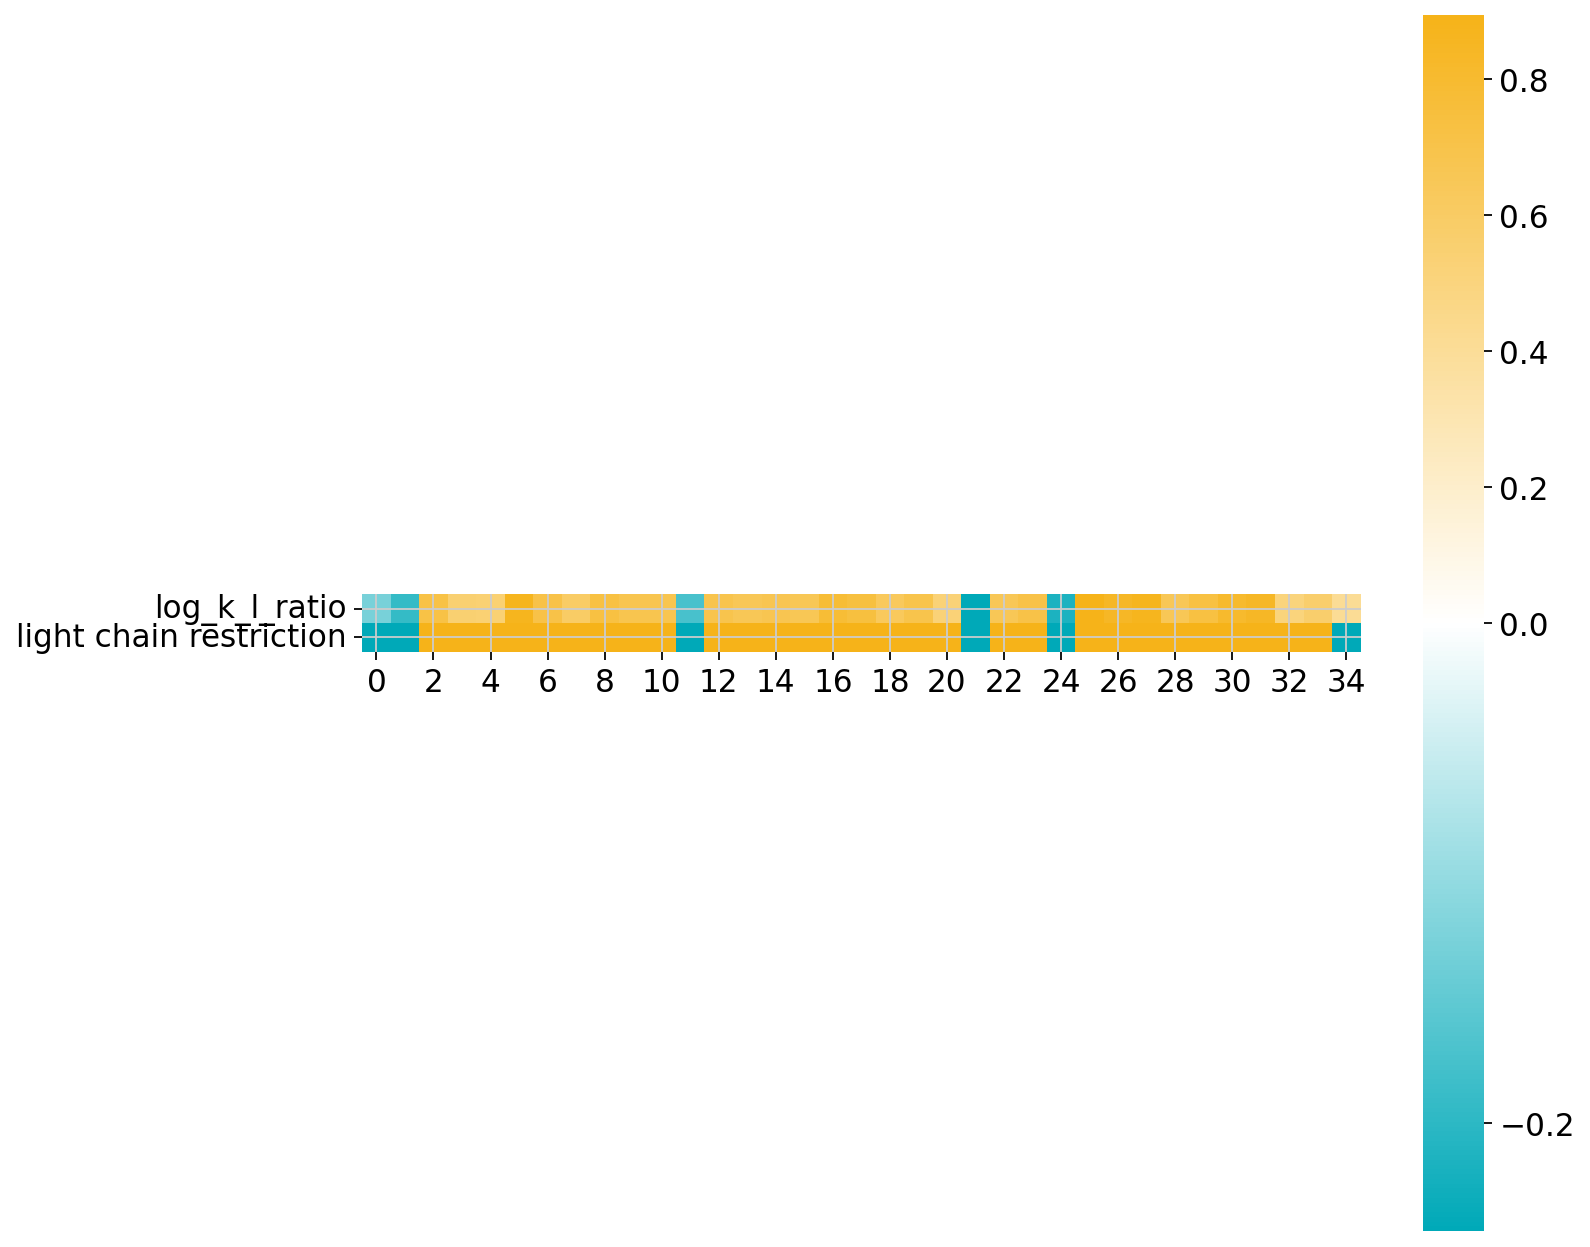

In [8]:
# visualize kl ratio in heatmap
heat = mean_ratios.loc[:, ['log_k_l_ratio', 'light chain restriction']].copy()

# Replace 'kappa' and 'lambda' with binary values for the ground truth annotation
heat.replace({'light chain restriction': {'kappa': heat['log_k_l_ratio'].max(), 'lambda': heat['log_k_l_ratio'].min()}}, inplace=True)

colors = ['#00A9B8', 'white', '#F6B319']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

norm = TwoSlopeNorm(vmin=heat['log_k_l_ratio'].min(), vcenter=0, vmax=heat['log_k_l_ratio'].max())

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(heat.T, square=True, ax = ax, cmap = cmap, norm = norm)

fig.savefig(f'{figure_dir}heatmap_light_chain_restriction.pdf', bbox_inches='tight')

# compute frquencies for the query data

In [9]:
adata_query = adata[(adata.obs['model_type']=='query')].copy()

/tmp/ipykernel_3015/2388272004.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_table = adata_query.obs.groupby(['donor', 'cell_type']).size().unstack(fill_value=0)


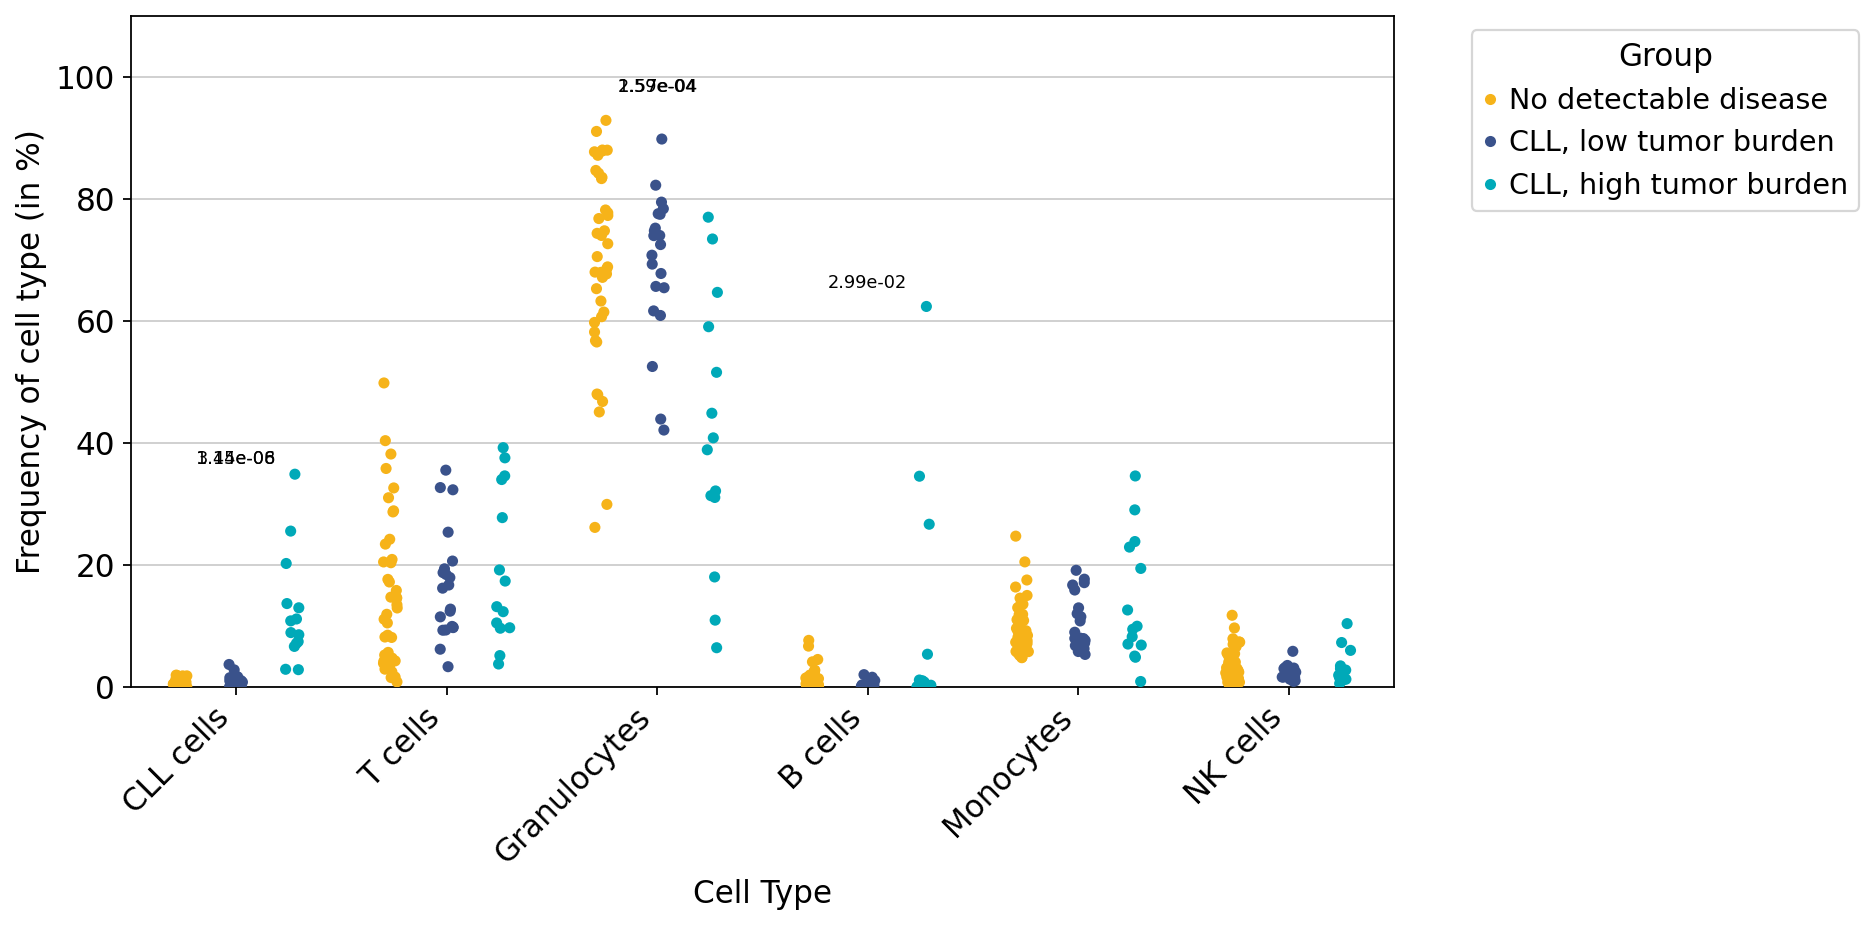

In [10]:
# Prepare the data for violin plots
freq_table = adata_query.obs.groupby(['donor', 'cell_type']).size().unstack(fill_value=0)
freq_table_normalized = freq_table.div(freq_table.sum(axis=1), axis=0)
res = pd.merge(freq_table_normalized.reset_index('donor'), md, on='donor')

cell_types = ['CLL cells', 'T cells', 'Granulocytes', 'B cells', 'Monocytes', 'NK cells']
freq_long = res.melt(id_vars=['donor', 'class'], var_name='cell_type', value_vars=cell_types, value_name='frequency')
freq_long['frequency'] = freq_long['frequency'] * 100

# Calculate pairwise Mann-Whitney U test p-values for each cell type
pairwise_p_values = {}

for cell_type in cell_types:
    group_data = freq_long[freq_long['cell_type'] == cell_type]
    groups = group_data['class'].unique()
    pairwise_comparisons = combinations(groups, 2)

    for group1, group2 in pairwise_comparisons:
        data1 = group_data[group_data['class'] == group1]['frequency']
        data2 = group_data[group_data['class'] == group2]['frequency']

        if len(data1) > 0 and len(data2) > 0:  # Ensure both groups have data
            _, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
            if p_val < 0.05:
                pairwise_p_values[(cell_type, group1, group2)] = p_val

# Define group colors and order
group_colors = {'CLL, high tumor burden': '#00A9B8', 'CLL, low tumor burden': '#3A528B', 'No detectable disease': '#F6B319'}
group_order = ['No detectable disease', 'CLL, low tumor burden', 'CLL, high tumor burden']

# Create violin plots
plt.figure(figsize=(12, 6))
ax = sns.stripplot(
    data=freq_long,
    x='cell_type',
    y='frequency',
    hue='class',
    dodge=True,
    palette=group_colors,
    # split=False,
    hue_order=group_order,
    order=cell_types,
)

# Add p-value annotations above the violins
for (cell_type, group1, group2), p_val in pairwise_p_values.items():
    cell_type_index = cell_types.index(cell_type)
    x_pos = cell_type_index  # X position of the annotation
    y_pos = freq_long[freq_long['cell_type'] == cell_type]['frequency'].max() * 1.05
    text = f"{p_val:.2e}"
    ax.text(x_pos, y_pos, text, ha='center', fontsize=8, color='black')

plt.ylim(0, 110)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency of cell type (in %)')
plt.xlabel('Cell Type')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(f'{figure_dir}violinplot_cell_type_frequencies_query_data.pdf')
plt.show()

In [11]:
# plot abundance and uncertainty in same heatmap as k/l raito
mean_ratios = mean_ratios.join(res[['CLL cells', 'donor']].set_index('donor'), on='donor', how='left')
mean_ratios.sort_values('CLL cells', inplace=True, ascending=False)

/tmp/ipykernel_3015/982023698.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat1.replace({'light chain restriction': {'kappa': heat1['log_k_l_ratio'].max(),


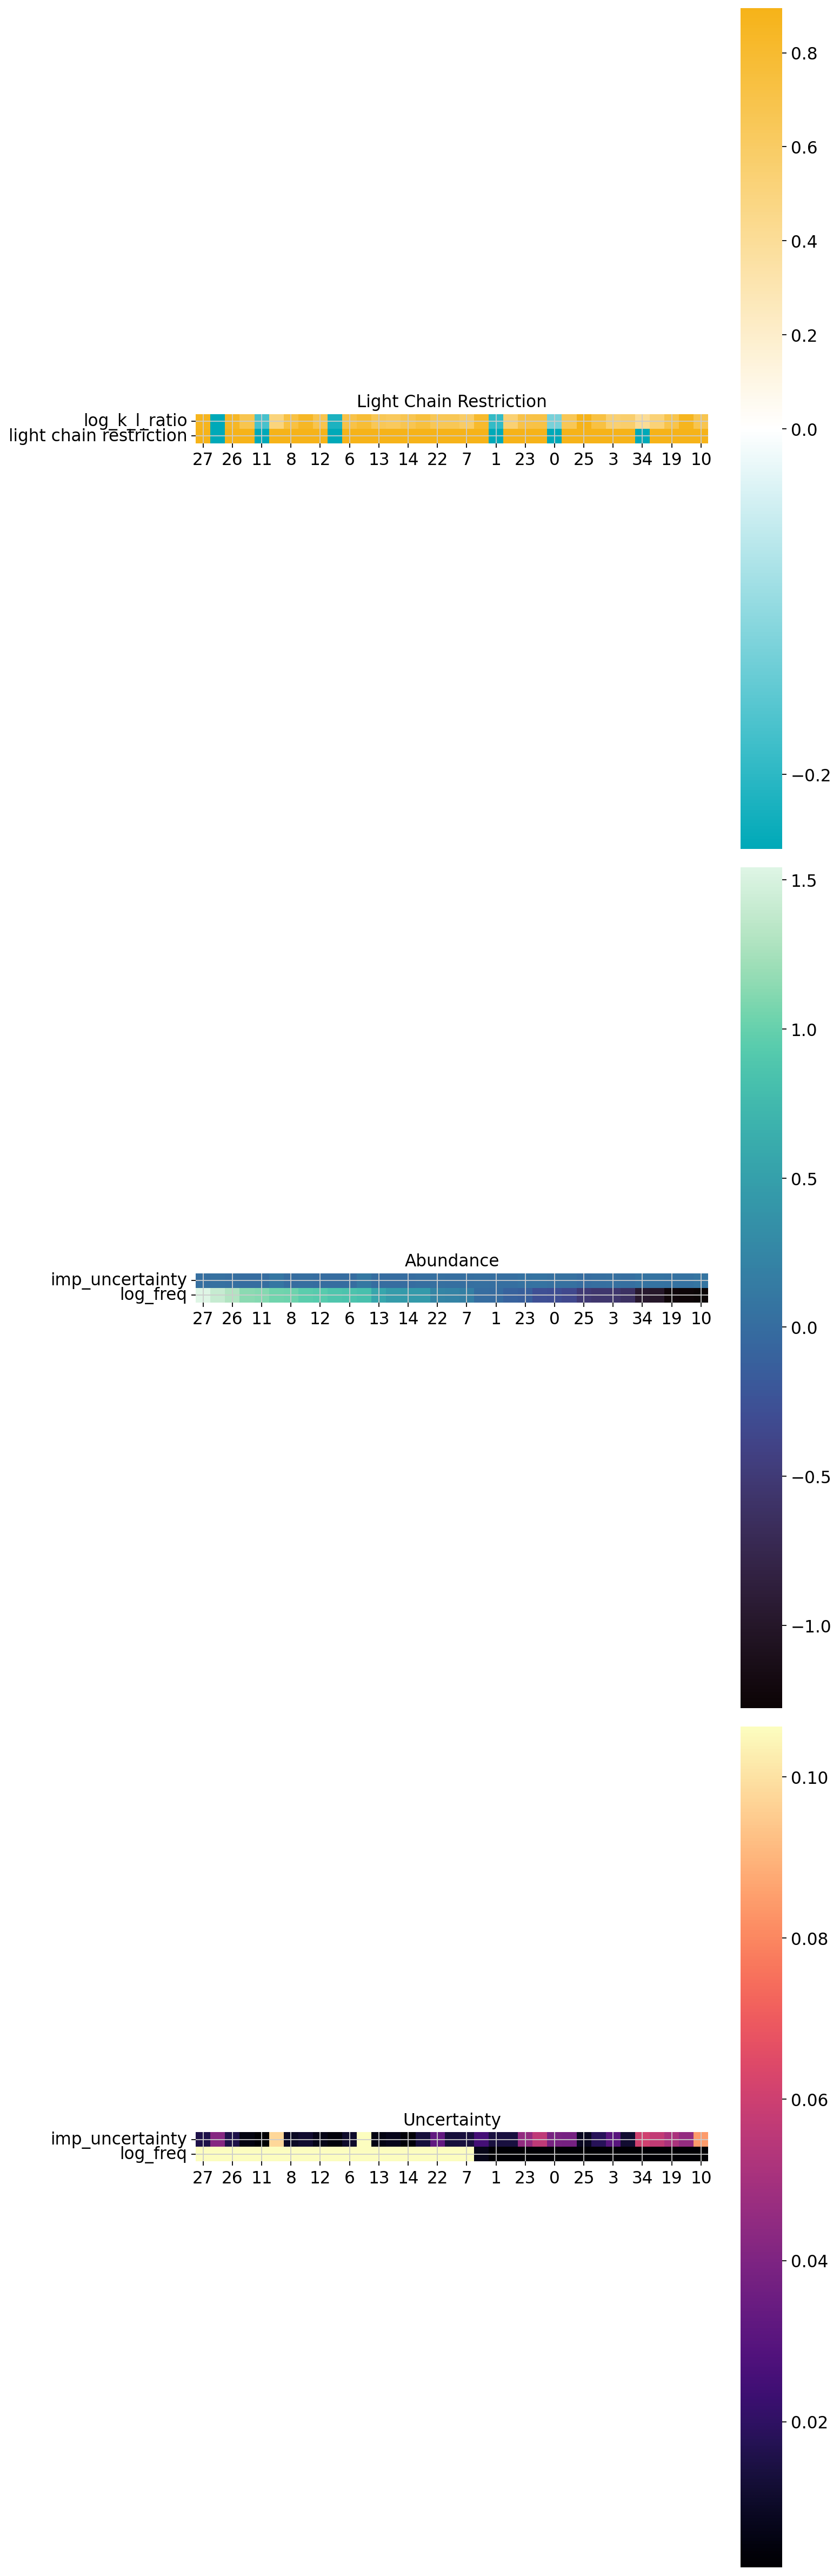

In [13]:
# draw heatmaps for the different features
colors = ['#00A9B8', 'white', '#F6B319']
cmap_custom = LinearSegmentedColormap.from_list('custom_cmap', colors)

# heat1
heat1 = mean_ratios.loc[:, ['log_k_l_ratio', 'light chain restriction']].copy()
heat1.replace({'light chain restriction': {'kappa': heat1['log_k_l_ratio'].max(),
                                           'lambda': heat1['log_k_l_ratio'].min()}}, inplace=True)
norm1 = TwoSlopeNorm(vmin=heat1['log_k_l_ratio'].min(), vcenter=0, vmax=heat1['log_k_l_ratio'].max())

# heat2
heat2 = mean_ratios.loc[:, ['CLL cells', 'imp_uncertainty']].copy()
heat2['log_freq'] = np.log10(heat2['CLL cells'] * 100)

# heat3
norm3 = plt.Normalize(vmin=heat2['imp_uncertainty'].min(), vmax=heat2['imp_uncertainty'].max())

# Combine into one figure
fig_combined, axes = plt.subplots(3, 1, figsize=(10, 30)) 

# Plot the first heatmap
sns.heatmap(heat1.T, square=True, ax=axes[0], cmap=cmap_custom, norm=norm1)
axes[0].set_title("Light Chain Restriction")
axes[0].set_ylabel("")  

# Plot the second heatmap
sns.heatmap(heat2[['imp_uncertainty', 'log_freq']].T, square=True, ax=axes[1], cmap='mako')
axes[1].set_title("Abundance")
axes[1].set_ylabel("") 

# Plot the third heatmap
sns.heatmap(heat2[['imp_uncertainty', 'log_freq']].T, square=True, ax=axes[2], cmap='magma', norm=norm3)
axes[2].set_title("Uncertainty")
axes[2].set_ylabel("") 

# Adjust layout and save
fig_combined.tight_layout()
fig_combined.savefig(f"{figure_dir}combined_heatmaps.pdf", bbox_inches='tight')
plt.show()

In [14]:
# compute k/l ratio for all cells
adata_cll_comb = adata[(adata.obs['cell_type']=='CLL cells') & (adata.obs['model_type']=='query')].copy()
k_l_ratio = np.array((adata_cll_comb[:,'Kappa'].layers['scaled'].flatten())/ (adata_cll_comb[:,'Lambda'].layers['scaled'].flatten()))
adata_cll_comb.obs['k_l_ratio'] = k_l_ratio

mean_ratios_comb = adata_cll_comb.obs.groupby(['model_type', 'donor'])['k_l_ratio'].mean().reset_index().join(md.set_index('donor'), on='donor', how='left')
mean_ratios_comb['log_k_l_ratio'] = np.log10(mean_ratios_comb['k_l_ratio'])

res_comb = res.merge(mean_ratios_comb.loc[:,['donor', 'log_k_l_ratio']])
res_comb['CLL cells'] = res_comb['CLL cells'] * 100

/tmp/ipykernel_3015/1550394768.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_ratios_comb = adata_cll_comb.obs.groupby(['model_type', 'donor'])['k_l_ratio'].mean().reset_index().join(md.set_index('donor'), on='donor', how='left')


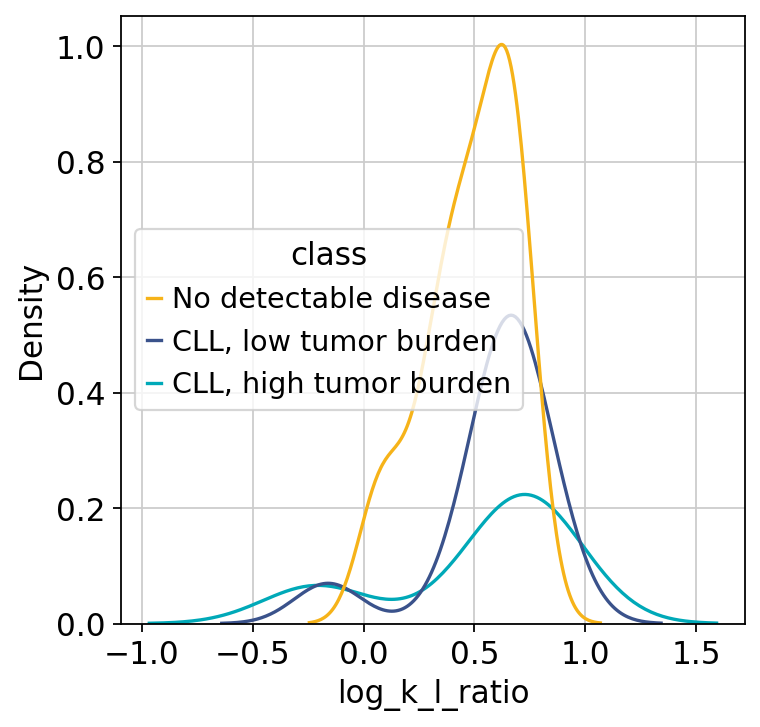

In [15]:
# plot histogram for kl ratio
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(mean_ratios_comb, x='log_k_l_ratio', hue='class', palette=group_colors, ax = ax)

fig.savefig(f'{figure_dir}k_l_ratio_density.pdf', bbox_inches='tight')

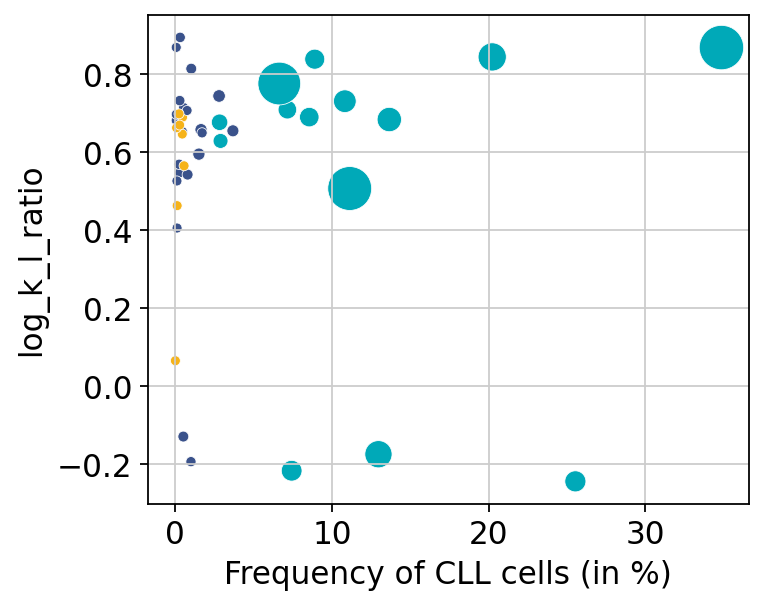

In [16]:
# scatter plot of freq CLL vs kl ratio
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=res_comb,
    x='CLL cells',
    y='log_k_l_ratio',
    hue='class',
    size='freq CLL cells among total',
    sizes=(20, 400),
    palette=group_colors,  # Custom group colors
)
plt.xlabel('Frequency of CLL cells (in %)')
plt.tight_layout()
plt.legend([],[], frameon=False)
plt.savefig(f'{figure_dir}scatterplot_freq_CLL_vs_kl_ratio.pdf')

# train a decision tree classifier

In [17]:
enc_dict = {'control': 0, 'cases': 1}

dec_tree = tree.DecisionTreeClassifier(max_depth=3)
X = res_comb[['CLL cells', 'log_k_l_ratio']]
y = res_comb['group'].map(enc_dict)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

dt_clf = tree.DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [97]:
yhat_test = dt_clf.predict(X_test)

In [98]:
y_prob = dt_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)

Text(0.1, 0.8, 'AUC:  0.80')

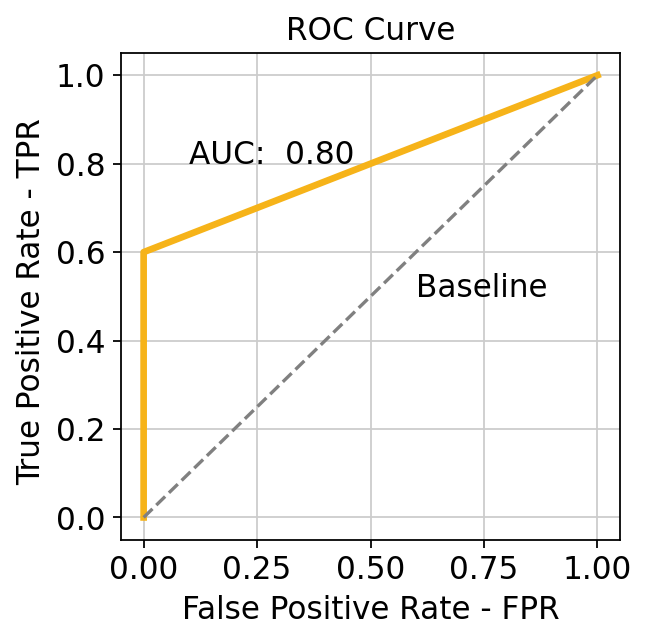

In [99]:
auc_tc = auc(fpr, tpr)

plt.plot(fpr,tpr, color = '#F6B319', linewidth=3)
plt.plot([0,1],[0,1],color="grey",linestyle="--")
 
plt.xlabel("False Positive Rate - FPR")
plt.ylabel("True Positive Rate - TPR ")
plt.title("ROC Curve")
plt.text(0.6,0.5,"Baseline")
plt.text(0.1,0.8, f"AUC: {auc_tc: .2f}")

/tmp/ipykernel_3015/3987082081.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cls = res_comb['class'].replace({'CLL, high tumor burden': 2,
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


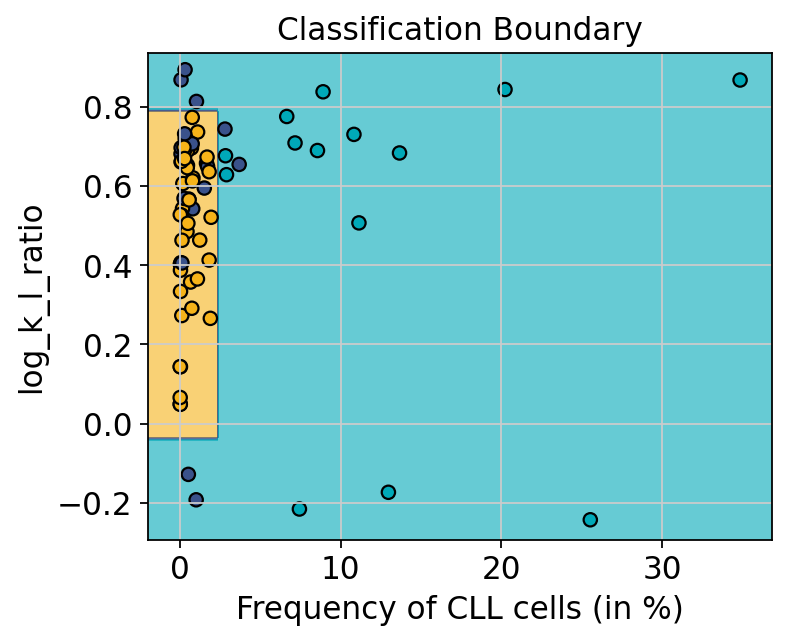

In [49]:
# visualize decision boundaries
cls = res_comb['class'].replace({'CLL, high tumor burden': 2, 
                                 'CLL, low tumor burden': 1, 
                                 'No detectable disease': 0}, inplace=False)

x_min, x_max = X.iloc[:, 0].min() - 2, X.iloc[:, 0].max() + 2
y_min, y_max = X.iloc[:, 1].min() - 0.05, X.iloc[:, 1].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict on the grid
Z = dt_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(5, 4))
colors = ListedColormap([*group_colors.values()][::-1])  
plt.contourf(xx, yy, Z, alpha=0.6, cmap=colors)

# Scatter plot with cls-based coloring
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=cls, edgecolor='k', cmap=colors)

plt.xlabel('Frequency of CLL cells (in %)')
plt.ylabel('log_k_l_ratio')
plt.title('Classification Boundary')
plt.savefig(f'{figure_dir}decision_boundary_decision_tree.pdf')
plt.show()

In [79]:
from sklearn.model_selection import cross_val_score
roc_auc = cross_val_score(dt_clf, X, y, cv=5, scoring='roc_auc')

In [80]:
roc_auc.mean()

0.7428571428571429

In [81]:
roc_auc.std()

0.0893571143085486